# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to better understand the data

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set notebook preferences**

In [2]:
#Set options for pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set visualization preferences
plt.style.use('Solarize_Light2')

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

#Set path to write visuals
viz_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Visualizations\Modeling'

#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Data\03_Processed'

**Read in data**

In [3]:
#Read in training data and labels
df = pd.read_csv(path + '/2020_0715_Listings_Processed.csv', index_col=0)

**Data Overview**

In [4]:
#Display data and shape
print('Data shape: {}\n'.format(df.shape))
display(df.head())

Data shape: (116180, 12)



,accommodates,amenities_count,bedrooms,beds,cleaning_fee,guests_included,neighbourhood_cleansed_encoded,price,security_deposit,room_type,property_type,bed_type
0,3,26,1.000,2.000,100.000,2,177.720,170.000,100.000,Entire home/apt,Apartment,Real Bed
1,2,16,1.000,1.000,50.000,1,159.541,65.000,200.000,Private room,Apartment,Real Bed
3,6,33,2.000,3.000,125.000,1,177.720,255.000,0.000,Entire home/apt,Apartment,Real Bed
4,3,34,1.000,2.000,50.000,2,172.888,139.000,0.000,Private room,Condominium,Real Bed
5,2,23,1.000,1.000,50.000,1,177.800,135.000,2.000,Private room,House,Real Bed


### Data Preparation

**Split data into training and test sets**

In [5]:
#Seperate labels from data
X = df.drop('price', axis = 1)
y = df['price']

#Check
print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

X shape:(116180, 11)
y shape:(116180,)


In [6]:
#Import splitter
from sklearn.model_selection import train_test_split

#Split Data
X_train, X_test, y_train, y_test =  train_test_split(
                                    X,y, test_size = .2, random_state = 42)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(92944, 11) | Training labels:(92944,)
Test data:(23236, 11) | Test labels:(23236,)


# Model Development 

## Build Preprocessor

In [7]:
#Read in Libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

#Init column transformer for data type
numeric_transformer = Pipeline([('scaler', MinMaxScaler())])
categorical_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Subset numeric and cat features
num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include='object').columns

#Store column transform for pipeline
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_features),
                                              ('cat', categorical_transformer, cat_features)],
                                             n_jobs=-1,)

## Build pipeline with base model: DecisionTreeRegressor

In [8]:
#Init base model as regressor
regressors = DecisionTreeRegressor(random_state=12, max_depth=10)

#Init pipe
pipe = Pipeline([('preprocessor', preprocessor),
                ('model', regressors)])

**Make and Evaluate Predictions**

Base DecisionTreeRegressor Evaluation Metrics:
R2: 0.6868373361815125
MAE: 34.04415139535736 
MAPE: 24.948657875817315
MSE: 2386.930285888404
RMSE: 48.856220544454764


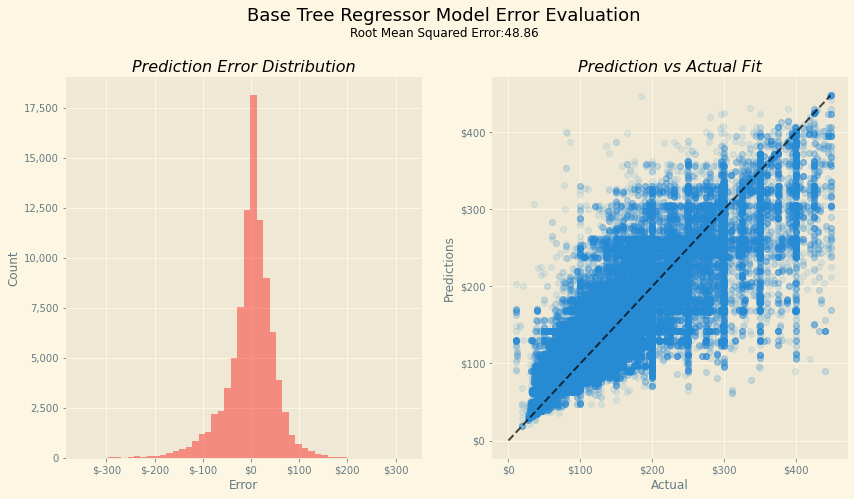

In [9]:
#Read in libraries from local machine
from Model_Evaluation import regression_metrics, prediction_error_df, prediction_fit_eval

#Implement model
preds = cross_val_predict(pipe, X_train,y_train, n_jobs=-1)

#Evaluate
base_metrics = regression_metrics('Base DecisionTreeRegressor', preds, y_train)

#View Error distribution and fit
base_errors = prediction_error_df(preds, y_train)
prediction_fit_eval(base_errors, model_name='Base Tree Regressor Model', rmse = base_metrics['rmse']);

#Save figure
plt.savefig(viz_path + '/base_model_pred_fit.png', bbox_inches='tight')

In [10]:
#Display error dataframe
display(base_errors.sort_values(by = 'error_%', ascending= False).head(20))

,predictions,actual,error,error_%
95835,202.574,10.000,192.574,1925.745
70617,170.107,10.000,160.107,1601.073
87218,170.107,10.000,160.107,1601.073
97983,170.107,10.000,160.107,1601.073
76296,170.107,10.000,160.107,1601.073
118323,169.483,10.000,159.483,1594.826
36553,169.483,10.000,159.483,1594.826
102524,169.483,10.000,159.483,1594.826
81099,167.010,10.000,157.010,1570.099
21085,167.010,10.000,157.010,1570.099


# Test Ensemble and Boosting Methods

In [11]:
#Import Libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

## Build initial pipeline

Goal: Test base model version of each Ensemble and Boosting method to evaluate performance on training data. Best performing model(according to RMSE) will be further tuned and deployed on test data.

In [12]:
#Create a list of model names to be used in a print funtion later when aggregating model evaluation metrics
model_names = [
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'XGBRegressor',
]

#Init models into a list to loop over in pipeline to evaluate all base model performances
regressors = [
    RandomForestRegressor(random_state = 42, n_jobs=-1,max_depth=10),
    GradientBoostingRegressor(random_state = 42,max_depth=10),
    XGBRegressor(random_state = 42, n_jobs=-1,max_depth=10)
]

**Build preliminary pipeline, evaluate results, and select model for futher development**

RandomForestRegressor Evaluation Metrics:
R2: 0.7260108560664837
MAE: 32.68345990828747 
MAPE: 24.18350713000981
MSE: 2088.3491591405304
RMSE: 45.69845904557976
GradientBoostingRegressor Evaluation Metrics:
R2: 0.8971715252478775
MAE: 18.42168143901197 
MAPE: 13.948848104692802
MSE: 783.7600997666016
RMSE: 27.995715739494884
XGBRegressor Evaluation Metrics:
R2: 0.9451930450577272
MAE: 11.09465021845149 
MAPE: 8.47606867741583
MSE: 417.7393915158963
RMSE: 20.43867391774467


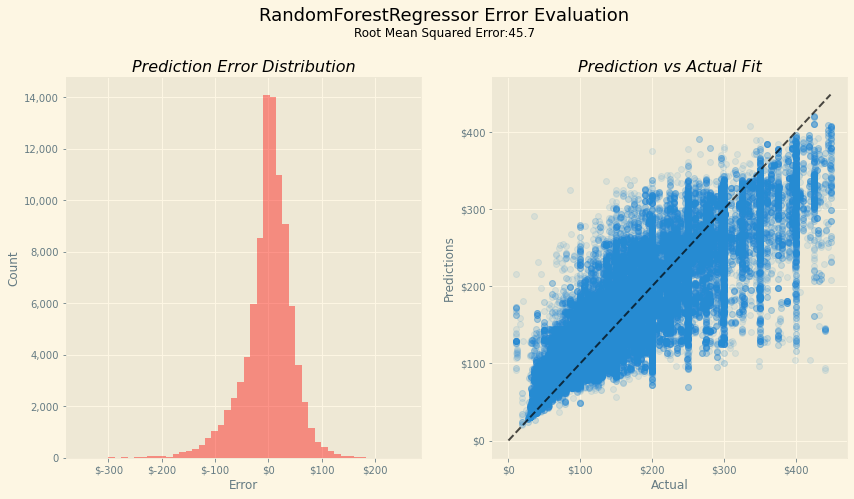

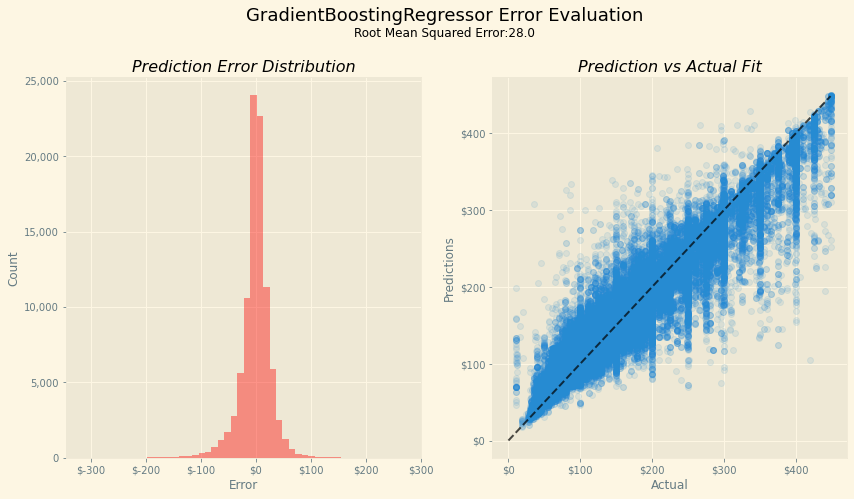

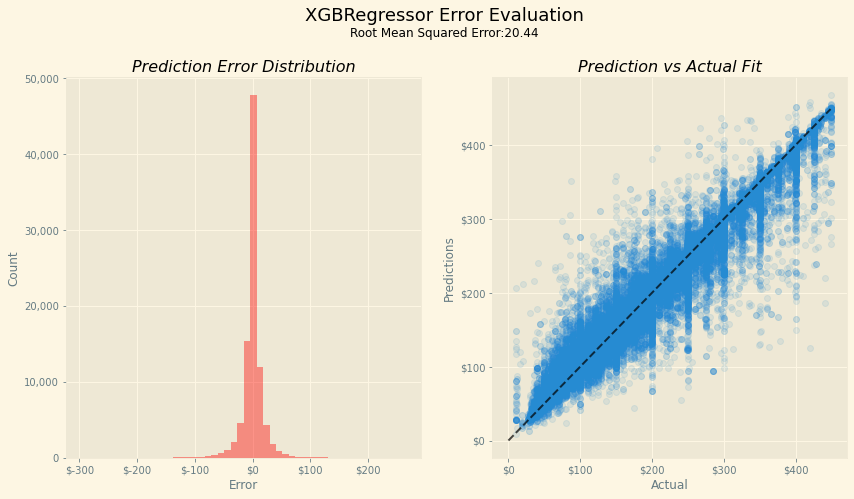

In [13]:
#Implement pipe that tests evaluation metrics for all regressors
for name,regressor in zip(model_names, regressors):
    pipe.steps.pop(1) #Delete previous model in pipeline
    pipe.steps.append(['model',regressor]) #Add new model

    predictions = cross_val_predict(pipe, X_train, y_train,cv=3, n_jobs=-1)
 
    #Evaluate
    metrics = regression_metrics(name,predictions, y_train, return_dict=True)
    error_df = prediction_error_df(predictions, y_train)
    prediction_fit_eval(error_df, model_name=name, rmse=metrics['rmse'])
    
    #Save error dist and prediction fit plot
    plt.savefig(viz_path + '/' + name + '_pred_fit.png', bbox_inches='tight')

# Tune Hyperparameters - XGBRegressor

**RandomSearch CV**

In [14]:
#Init libraries
from sklearn.model_selection import RandomizedSearchCV

#Set list with evaluation metrics for RandomizedSearchCV
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

#Create list of model names for later loop
model_name = [
    'XGBRegressor',
    ]

#Init models 
regressor = [XGBRegressor()]

#Init parameters for RandomSearchCV evaluation to search over
parameters = [
    {'model__n_estimators':[250, 300, 350],
    'model__max_depth':[15, 20, 25],
    'model__learning_rate': [.01,.1],
    'model__random_state' : [42], 
    'model__n_jobs': [-1]}
]

In [15]:
#Create pipeline with parameter grid to search over base models(randomsearch cv)
for name, xgbr, parameter in zip(model_name, regressor, parameters):
    pipe.steps.pop(1) #Delete previous model in pipeline
    pipe.steps.append(['model',xgbr]) #Add new model
    
    reg = RandomizedSearchCV(pipe, param_distributions=parameter, n_jobs=-1, scoring=scoring, refit='neg_mean_squared_error')
    reg.fit(X_train, y_train)
    
    print("{} Random Search Results:".format(name))
    print('Avg RMSE:',np.mean(np.sqrt(-1 * (reg.cv_results_['mean_test_neg_mean_squared_error']))))
    print('Avg MAE:',np.mean(-1 * reg.cv_results_['mean_test_neg_mean_absolute_error']))
    r2 = np.mean(reg.cv_results_['mean_test_r2'])
    print('Avg R2:',r2)
    print("\n The best parameters across searched parameters:\n", reg.best_params_)
    print("========================================================")

XGBRegressor Random Search Results:
Avg RMSE: 18.503788197750247
Avg MAE: 8.866749982233639
Avg R2: 0.9538574610856031

 The best parameters across searched parameters:
 {'model__random_state': 42, 'model__n_jobs': -1, 'model__n_estimators': 350, 'model__max_depth': 15, 'model__learning_rate': 0.1}


In [16]:
#Store reg.best_estimator_
tuned_xgbr = reg.best_estimator_

#Print specs
print('Tuned XGBRegressor Pipeline:\n',tuned_xgbr)

Tuned XGBRegressor Pipeline:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['accommodates', 'amenities_count', 'bedrooms', 'beds', 'cleaning_fee',
       'guests_included', 'neighbourhood_cleansed_encoded',
       'security_deposit'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate

**Evaluate Fit**

In [17]:
#Get predictions
preds = cross_val_predict(tuned_xgbr, X_train, y_train, n_jobs=-1, cv = 5)

Tuned XGBRegressor Evaluation Metrics:
R2: 0.9677864748940238
MAE: 4.911559105678728 
MAPE: 3.5673978245236735
MSE: 245.53194736920574
RMSE: 15.669459064345704


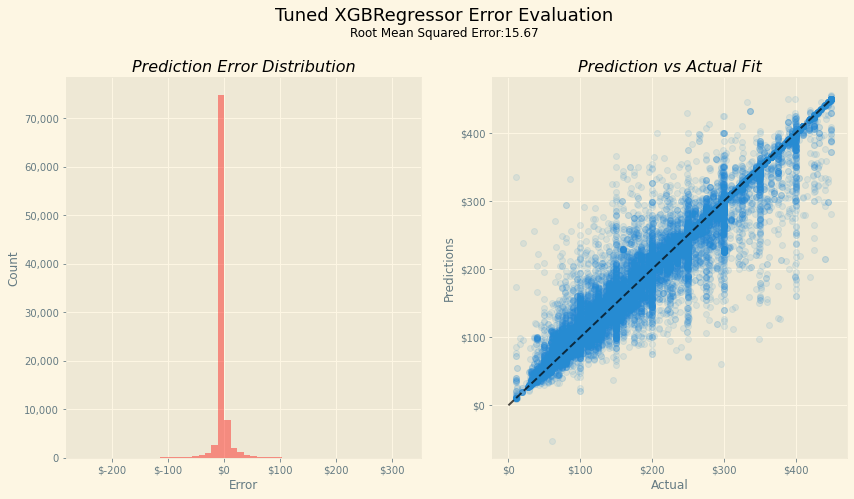

In [18]:
#Get stats and view error distribution/prediction fit eval
xgbr_metrics = regression_metrics('Tuned XGBRegressor', preds, y_train)
xgbr_error = prediction_error_df(preds, y_train)
prediction_fit_eval(xgbr_error, model_name='Tuned XGBRegressor', rmse=xgbr_metrics['rmse']),

#Save error dist and prediction fit plot
plt.savefig(viz_path + '/Tuned_XGBR_Error_Fit_Evaluation.png', bbox_inches='tight')

In [19]:
xgbr_error.sort_values('error_%', ascending=False, ).head(20)

,predictions,actual,error,error_%
95835,334.333,10.000,324.333,3243.332
40576,174.155,10.000,164.155,1641.547
27154,238.054,20.000,218.054,1090.272
118323,84.896,10.000,74.896,748.957
70617,76.628,10.000,66.628,666.275
58307,255.329,35.000,220.329,629.512
92207,72.806,10.000,62.806,628.059
81099,72.806,10.000,62.806,628.059
85377,99.145,16.000,83.145,519.658
40838,90.001,16.000,74.001,462.507


**View Feature Importances**

In [20]:
#Get feature names of transformed cat features
transformed_cats = tuned_xgbr['preprocessor'].transformers_[1][1]['encoder'].get_feature_names(cat_features).tolist()

#Combine original num feats with transformed cats
original_features = [*num_features, *transformed_cats]

#Get feature importances from regressor
feat_import = tuned_xgbr.named_steps['model'].feature_importances_

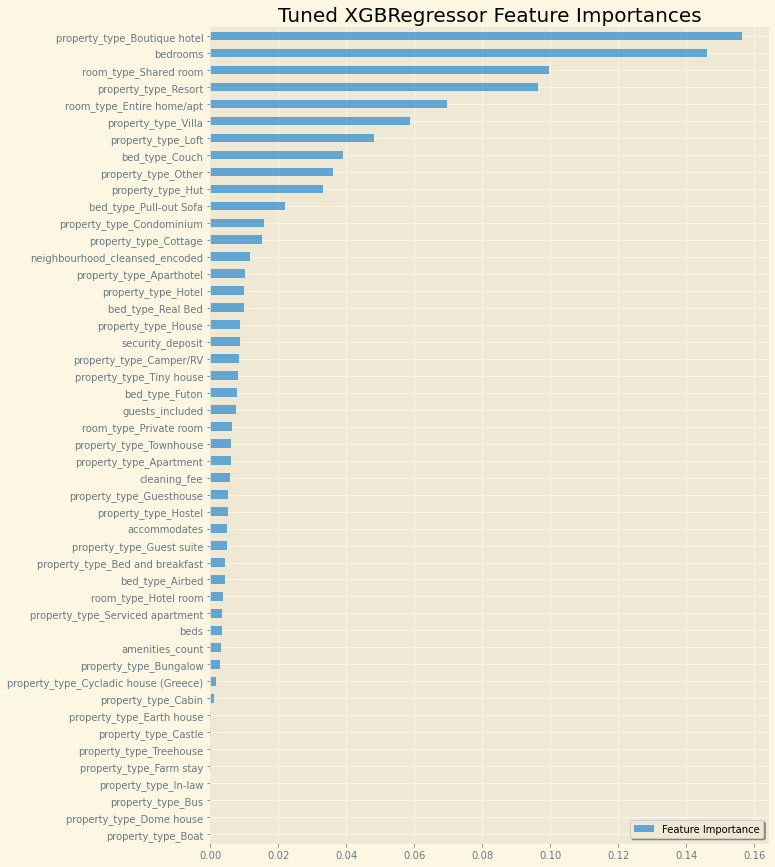

In [23]:
#Store in data frame with original_features as index. Sort values
feature_importances = pd.DataFrame(feat_import, index=original_features,columns=['feature_importance'])
feature_importances.sort_values(by = 'feature_importance', ascending = False, inplace = True)

#Create fig
f, ax = plt.subplots(figsize = (10,15), )

#Plot Feature Importance
feature_importances.plot(kind = 'barh', ax=ax, alpha = .7)

#Set plot aesthetics
ax.invert_yaxis()
ax.set_title('Tuned XGBRegressor Feature Importances', fontsize = 20, )
ax.legend(['Feature Importance'], shadow = True, frameon = True, loc = 'lower right')

#Save error dist and prediction fit plot
plt.savefig(viz_path + '/Tuned_XGBR_Feat_Importance.png', bbox_inches='tight')

**Save/Load Tuned Model**

In [22]:
#Set path to save tuned_xgbr
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Airbnb - San Francisco Listings Analysis\Project_Codes\04_Modeling\Saved_Models'

#Write tuned_xgbr pipeline
import joblib
joblib.dump(tuned_xgbr, path + '/XGBR_Price_Predictor.pkl', compress = 1)

# #Load tuned_xgbr pipeline
# tuned_xgbr = joblib.load(path + '/XGBR_Price_Predictor.pkl')

['C:\\Users\\kishe\\Documents\\Data Science\\Projects\\Python Projects\\In Progress\\Airbnb - San Francisco Listings Analysis\\Project_Codes\\04_Modeling\\Saved_Models/XGBR_Price_Predictor.pkl']

# Deploy

In [24]:
#Fit to test data
test_predictions = cross_val_predict(tuned_xgbr, X_test,y_test, cv = 10, n_jobs=-1)

Tuned XGBRegressor Evaluation Metrics:
R2: 0.9030234197085759
MAE: 10.992785869684743 
MAPE: 7.75146171477146
MSE: 731.435920053485
RMSE: 27.045072010506555


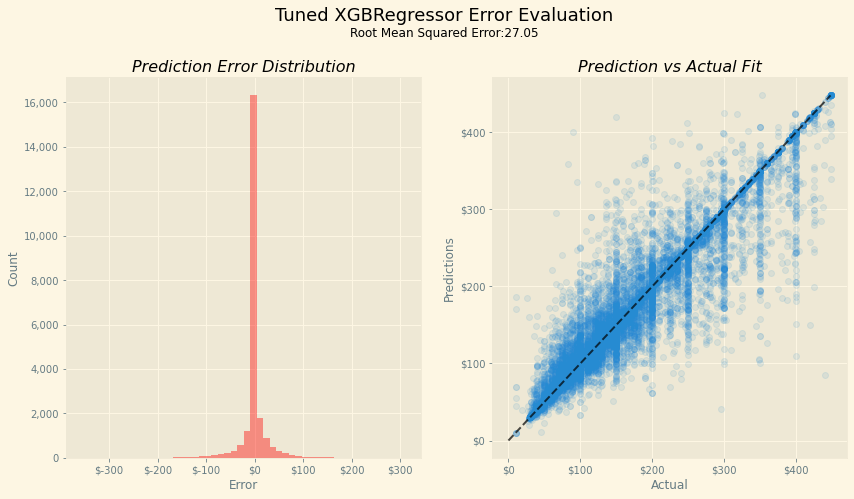

In [25]:
#Get stats and view error distribution/prediction fit eval
xgbr_metrics = regression_metrics('Tuned XGBRegressor', test_predictions, y_test)
xgbr_error = prediction_error_df(test_predictions, y_test)
prediction_fit_eval(xgbr_error, model_name='Tuned XGBRegressor', rmse=xgbr_metrics['rmse'])

#Save figure
plt.savefig(viz_path + '/Tuned_XGBR_Deployed_Prediction_Results.png', bbox_inches='tight')

In [26]:
xgbr_error.sort_values(by = 'error_%', ascending=False).head(20)

,predictions,actual,error,error_%
10391,186.308,10.000,176.308,1763.083
6671,170.107,10.000,160.107,1601.074
102256,184.383,26.000,158.383,609.165
54921,70.059,10.000,60.059,600.593
48785,70.059,10.000,60.059,600.593
89978,159.942,29.000,130.942,451.523
25657,55.046,10.000,45.046,450.459
123091,45.019,10.000,35.019,350.193
48256,294.696,66.000,228.696,346.509
82351,399.831,90.000,309.831,344.257
